# Example solution of DAT300 compulsory assignment 1

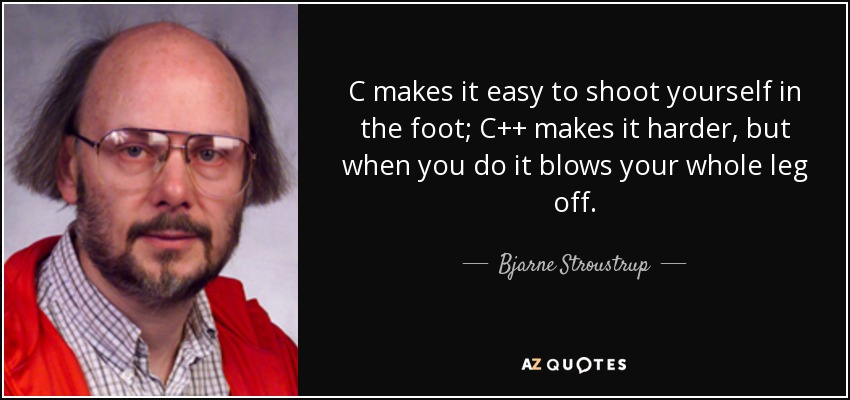

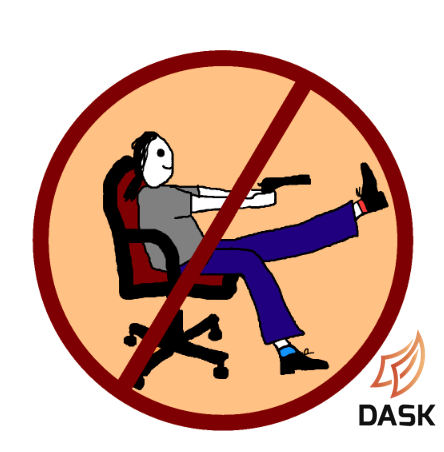

In [1]:
from os.path import join
import time

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import sklearn
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

from imblearn.ensemble import BalancedRandomForestClassifier

import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster, progress
from dask import delayed
from dask_ml.preprocessing import StandardScaler
from dask_ml.model_selection import train_test_split, IncrementalSearchCV, GridSearchCV
from dask_ml.linear_model import LogisticRegression
from dask_ml.decomposition import PCA
import dask.array as da
from dask_ml.xgboost import XGBClassifier
from dask_ml.wrappers import Incremental

import xgboost

DATA_PATH = 'data'
TRAININIG_DATA_ARRAY = 'training_array.h5'
TESTING_DATA_ARRAY = 'testing_array.h5'

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Load and prepared the data

In [2]:
X_df_train = dd.read_csv(join(DATA_PATH, 'X_train.csv'))
y_df_train = dd.read_csv(join(DATA_PATH, 'y_train.csv'))
df_train = X_df_train.merge(y_df_train, left_index=True, right_index=True)
df_train.head()

f1        f2        f3        f4        f5        f6        f7  \
0  0.650080  0.307440  0.306270  0.186580  0.179110  0.178230  0.174430   
1  0.098689  0.090486  0.063531  0.050347  0.049322  0.039360  0.007132   
2  0.079645  0.074518  0.071149  0.052691  0.039653  0.039214  0.037016   
3  0.148200  0.101180  0.091218  0.090486  0.051666  0.038042  0.021781   
4  0.148200  0.101180  0.091218  0.089167  0.051666  0.043755  0.040093   

         f8        f9      f10  ...      f154      f155      f156      f157  \
0  0.151130  0.139410  1.83790  ...  0.119300  0.119300  0.119300  0.119300   
1 -0.016892 -0.022459 -0.31062  ...  0.040767  0.040767  0.040767 -0.003073   
2  0.029252  0.010062 -0.34840  ...  0.040767  0.040767  0.040767  0.040767   
3  0.006546 -0.008835 -0.28662  ...  0.051966  0.051966  0.051966  0.051966   
4  0.021781  0.006546 -0.38027  ...  0.051966  0.051966  0.051966  0.051966   

       f158      f159      f160      f161      f162  Target  
0  0.119300  0.119300  0.119300  0.119300  0.119300     0.0  
1 -0.003073 -0.003073 -0.003073 -0.003073 -0.003073     0.0  
2  0.040767  0.040767  0.040767  0.040767  0.040767     0.0  
3  0.051966  0.051966  0.051966  0.051966  0.051966     0.0  
4  0.051966  0.051966  0.051966  0.051966  0.051966     0.0  

[5 rows x 163 columns]

### Small remark about pandas and dask

In [5]:
y_df_pandas = y_df_train.head(100)
X_df_pandas = X_df_train.head(100)

In [7]:
cond = y_df_pandas['Target'].isnull()

In [9]:
y_df_pandas[~cond].shape

(91, 1)

In [10]:
X_df_pandas[~cond].shape

(91, 162)

##### Let's do the same stuff in Dask

In [12]:
cond = y_df_train['Target'].isnull()

In [13]:
y_df_train[~cond].compute().shape

(2858793, 1)

In [14]:
X_df_train[~cond]

ValueError: Not all divisions are known, can't align partitions. Please use `set_index` to set the index.

Feature Request: Dataframe reindex support #4155

https://github.com/dask/dask/issues/4155

### Read test

In [15]:
X_df_test = dd.read_csv(join(DATA_PATH, 'X_test.csv'))
X_df_test.head()

f1        f2       f3        f4        f5        f6        f7  \
0 -0.180510 -0.192210 -0.20515 -0.215250 -0.215960 -0.215960 -0.216130   
1 -0.164560 -0.180510 -0.20515 -0.205680 -0.206210 -0.215250 -0.216130   
2 -0.044046 -0.050072 -0.05787 -0.066023 -0.067086 -0.067972 -0.087645   
3  0.340010  0.329020  0.31236  0.239520  0.235090  0.189360  0.173410   
4 -0.155170 -0.168990 -0.17927 -0.218790 -0.251050 -0.252110 -0.288620   

         f8       f9       f10  ...     f153     f154     f155     f156  \
0 -0.218260 -0.22907 -0.506090  ... -0.31380 -0.16709 -0.16709 -0.16709   
1 -0.218260 -0.22907 -0.506090  ... -0.31380 -0.16006 -0.16006 -0.16006   
2 -0.099342 -0.30971  1.230800  ... -0.13746 -0.10924 -0.10924 -0.10924   
3  0.161540  0.15835 -0.038613  ...  0.38480  0.42301  0.42301  0.42301   
4 -0.325130 -0.34622 -0.324840  ... -0.28911 -0.14978 -0.14978 -0.14978   

      f157     f158     f159     f160     f161     f162  
0 -0.16709 -0.16709 -0.16709 -0.16709 -0.16709 -0.16709  
1 -0.16709 -0.16709 -0.16709 -0.16709 -0.16709 -0.16709  
2 -0.10924 -0.10924 -0.10924 -0.10924 -0.10924 -0.10924  
3  0.32402  0.32402  0.32402  0.32402  0.32402  0.32402  
4 -0.25570 -0.25570 -0.25570 -0.25570 -0.32433 -0.32433  

[5 rows x 162 columns]

### Check for NaNs

In [16]:
print(X_df_test.isnull().sum(axis=0).compute().values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
print(df_train.isnull().sum(axis=0).compute().values)

[114491 118490 121080 130432 135668 138142 289446 292741 296966 114491
 118490 121080 130432 135668 138142 289446 292741 296966 114491 118490
 121080 130432 135668 138142 289446 292741 296966 114491 118490 121080
 130432 135668 138142 289446 292741 296966 114491 118490 121080 130432
 135668 138142 289446 292741 296966 114491 118490 121080 130432 135668
 138142 289446 292741 296966 114491 118490 121080 130432 135668 138142
 289446 292741 296966 114491 118490 121080 130432 135668 138142 289446
 292741 296966 114491 118490 121080 130432 135668 138142 289446 292741
 296966 114491 118490 121080 130432 135668 138142 289446 292741 296966
 114491 118490 121080 130432 135668 138142 289446 292741 296966 114491
 118490 121080 130432 135668 138142 289446 292741 296966 114491 118490
 121080 130432 135668 138142 289446 292741 296966 114491 118490 121080
 130432 135668 138142 289446 292741 296966 114491 118490 121080 130432
 135668 138142 289446 292741 296966 114491 118490 121080 130432 135668
 13814

In [6]:
len(y_df_train)

3155759

In [7]:
len(y_df_train.dropna())

2858793

In [8]:
len(X_df_train.dropna())

2858793

In [9]:
len(X_df_train.dropna().merge(y_df_train.dropna(), left_index=True, right_index=True))

2551335

In [3]:
len(df_train)

3155759

In [4]:
# Drop rows with missing values for train
df_train = df_train.dropna()

In [5]:
len(df_train)

2551335

Not implemented: dropna for columns ?!1

https://github.com/dask/dask/issues/4858

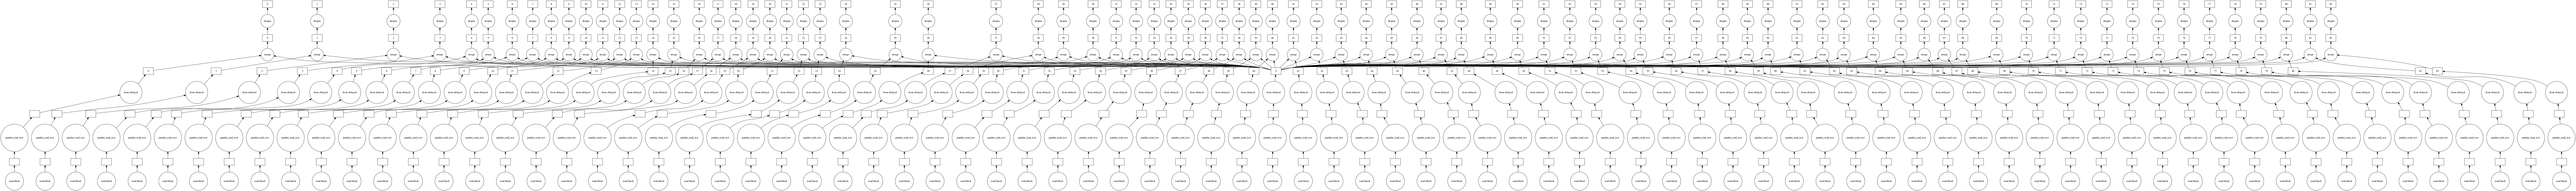

In [18]:
df_train.visualize()

## Storing to disk

In [12]:
h5py.File?

In [29]:
da.from_array?

In [17]:
h5py.File?

In [13]:
da.to_hdf5??

In [7]:
da.store??

In [22]:
# https://docs.dask.org/en/latest/array-creation.html

def writing_array(filename, dataset_name, darray, dtype=None):
    res = None
    dtype = darray.dtype if dtype is None else dtype
    with h5py.File(filename, 'a') as f: 
        d = f.require_dataset(dataset_name, shape=darray.shape,
                              dtype=dtype)
        res = da.store(darray, d, return_stored=True)[0]
    return res

def reading_array(filename, dataset_name, chunks='auto'):
    darray = None
    try:
        f = h5py.File(filename, 'r')
        darray = da.from_array(f[dataset_name], chunks=chunks)
    except:
        f.close()
    return darray


In [41]:
X_train_arr = df_train.drop(['Target'], axis=1).to_dask_array(lengths=True)
y_train_arr = df_train['Target'].to_dask_array(lengths=X_train_arr.chunks[0])

X_test_arr = X_df_test.to_dask_array(lengths=True)

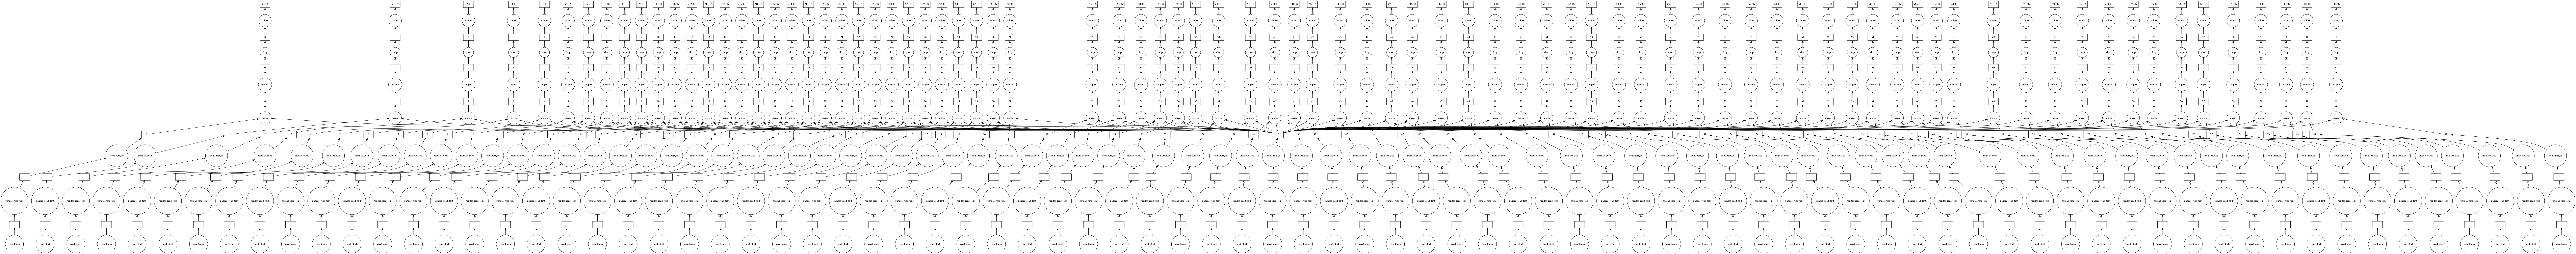

In [28]:
X_train_arr.visualize()

In [9]:
X_train_arr = writing_array(join(DATA_PATH, TRAININIG_DATA_ARRAY), 'X_train',
                            X_train_arr)

In [10]:
y_train_arr = writing_array(join(DATA_PATH, TRAININIG_DATA_ARRAY), 'y_train',
                            y_train_arr, dtype=np.uint8)

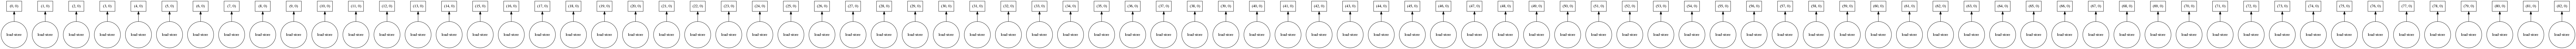

In [11]:
X_train_arr.visualize()

In [12]:
X_train_arr

dask.array<load-store-93e7d55c-f5a3-11e9-8f8c, shape=(2551335, 162), dtype=float64, chunksize=(33695, 162), chunktype=numpy.ndarray>

In [13]:
y_train_arr

dask.array<load-store-ac187974-f5a3-11e9-8f8c, shape=(2551335,), dtype=float64, chunksize=(33695,), chunktype=numpy.ndarray>

In [14]:
X_test_arr = writing_array(join(DATA_PATH, TESTING_DATA_ARRAY), 'X_test',
                           X_test_arr)

In [15]:
X_test_arr

dask.array<load-store-c17e3bfa-f5a3-11e9-8f8c, shape=(709039, 162), dtype=float64, chunksize=(36778, 162), chunktype=numpy.ndarray>

In [23]:
X_test_arr = reading_array(join(DATA_PATH, TESTING_DATA_ARRAY), 'X_test')

In [24]:
X_train_arr_read = reading_array(join(DATA_PATH, TRAININIG_DATA_ARRAY), 'X_train')

In [25]:
y_train_arr_read = reading_array(join(DATA_PATH, TRAININIG_DATA_ARRAY), 'y_train', X_train_arr_read.chunks[0])

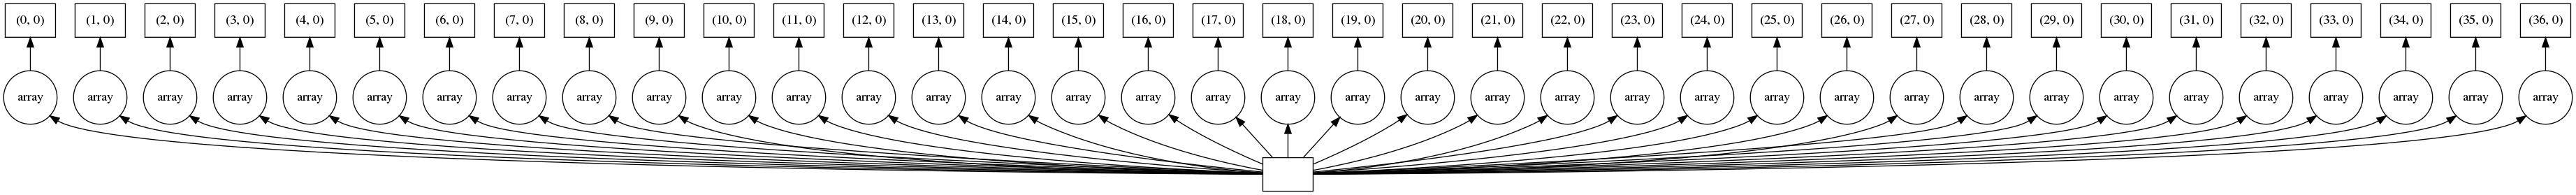

In [27]:
X_train_arr_read.visualize()

In [6]:
y_train_arr_read.chunks

((68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955),)

In [7]:
# or like this
# chunk_size = int(np.mean(X_train_arr.chunks[0]))
# X_train_arr = X_train_arr.rechunk({0: chunk_size})
# y_train_arr = y_train_arr.rechunk({0: chunk_size})

In [46]:
X_train_arr = X_train_arr_read
X_train_arr

dask.array<array, shape=(2551335, 162), dtype=float64, chunksize=(68955, 162), chunktype=numpy.ndarray>

In [47]:
y_train_arr = y_train_arr_read
y_train_arr

dask.array<array, shape=(2551335,), dtype=uint8, chunksize=(68955,), chunktype=numpy.ndarray>

# Split trainset into validation and training set

In [48]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_arr, y_train_arr,
                                                                          random_state=42, test_size=0.2)

In [34]:
X_train_split

dask.array<concatenate, shape=(2041068, 162), dtype=float64, chunksize=(55164, 162), chunktype=numpy.ndarray>

In [35]:
np.unique(y_train_split, return_counts=True)

(array([0, 1], dtype=uint8), array([1941274,   99794]))

In [37]:
np.unique(y_val_split, return_counts=True)

(array([0, 1], dtype=uint8), array([485444,  24823]))

# Modeling

## Train simple model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.850759 to fit


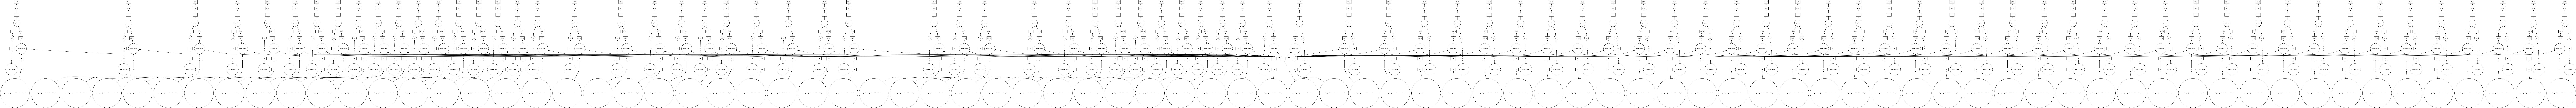

In [43]:
X_train_split.visualize()

In [44]:
tic = time.time()

lr = LogisticRegression(max_iter=1, solver='lbfgs', C=1, class_weight='balanced')
with ProgressBar():
    lr.fit(X_train_split, y_train_split)
    
toc = time.time()
print('Time: ', toc - tic)

[########################################] | 100% Completed | 39.7s
[########################################] | 100% Completed | 49.8s
[########################################] | 100% Completed | 49.5s
Time:  139.25084447860718


In [40]:
tic = time.time()

lr = LogisticRegression(max_iter=10, solver='lbfgs', C=1, class_weight='balanced')
with ProgressBar():
    lr.fit(X_train_split, y_train_split)
    
toc = time.time()
print('Time: ', toc - tic)

[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.6s
Time:  65.2927553653717


In [45]:
y_val_pred = lr.predict(X_val_split)
cf = confusion_matrix(y_val_split, y_val_pred)
print(cf)

[[485395      0]
 [ 24904      0]]


### Try PCA

In [70]:
LogisticRegression?

In [49]:
tic = time.time()

pipeline = Pipeline([
    ('pca', PCA(50)),
    ('clf', LogisticRegression(max_iter=50, solver='lbfgs', C=1, class_weight='balanced'))
])

with ProgressBar():
    pipeline.fit(X_train_split, y_train_split)

toc = time.time()
print('Time: ', toc - tic)

[########################################] | 100% Completed | 12.3s
[########################################] | 100% Completed | 13.2s
[########################################] | 100% Completed | 13.7s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed | 13.6s
[########################################] | 100% Completed | 13.6s
[########################################] | 100% Completed | 13.3s
[########################################] | 100% Completed | 13.5s
[########################################] | 100% Completed | 13.2s
[########################################] | 100% Completed | 13.6s
[########################################] | 100% Completed | 13.5s
Time:  147.59823489189148


In [85]:
np.sum(pipeline['pca'].explained_variance_ratio_)

0.9761563340498687

In [86]:
y_val_pred = pipeline.predict(X_val_split)
cf = confusion_matrix(y_val_split, y_val_pred)
print(cf)

[[485444      0]
 [ 24823      0]]


### Try scaling data

In [87]:
tic = time.time()

pipeline = Pipeline([
    ('std', StandardScaler()),
    ('clf', LogisticRegression(max_iter=50, solver='lbfgs', C=1, class_weight='balanced'))
])

with ProgressBar():
    pipeline.fit(X_train_split, y_train_split)

toc = time.time()
print('Time: ', toc - tic)

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.2s
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.6s
[########################################] | 100

In [88]:
y_val_pred = pipeline.predict(X_val_split)
cf = confusion_matrix(y_val_split, y_val_pred)
print(cf)

[[485444      0]
 [ 24823      0]]


## Try other models + preprocessings in a pipeline

https://ml.dask.org/hyper-parameter-search.html

1. If your dataset is relatively small or the underlying estimator doesn’t implement partial_fit, you can use dask_ml.model_selection.GridSearchCV or dask_ml.model_selection.RandomizedSearchCV. These are drop-in replacements for their scikit-learn counterparts, that should offer better performance and handling of Dask Arrays and DataFrames. The underlying estimator will need to be able to train on each cross-validation split of the data. See Drop-In Replacements for Scikit-Learn for more.
2. The second category of hyperparameter optimization uses incremental hyperparameter optimization. These should be used when your full dataset doesn’t fit in memory on a single machine.

In [50]:
GridSearchCV?

In [ ]:
tic = time.time()

params = {
    'loss': ['hinge', 'log'],
    'alpha': np.logspace(-4, -1, 4),
    'class_weight': ['balanced', {0: 0.05, 1: 0.95}]
}

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = GridSearchCV(SGDClassifier(), params, scoring=f1_s)

with ProgressBar():
    gs.fit(X_train_arr, y_train_arr)

toc = time.time()
print('Time: ', toc - tic)

In [ ]:
tic = time.time()

pipeline = Pipeline([
    ('clf', SGDClassifier())
])

params = {
    'clf__loss': ['hinge', 'log'],
    'clf__alpha': np.logspace(-4, -1, 4),
    'clf__class_weight': ['balanced', {0: 0.05, 1: 0.95}]
}

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = GridSearchCV(pipeline, params, scoring=f1_s)

with ProgressBar():
    gs.fit(X_train_arr, y_train_arr)

toc = time.time()
print('Time: ', toc - tic)

In [ ]:
tic = time.time()

pipeline = Pipeline([
    ('prep', PCA()),
    ('clf', SGDClassifier())
])

params = [
    {
        'prep': [PCA()],
        'prep__n_components': [20, 50, 80],
        'clf': [SGDClassifier()],
        'clf__loss': ['hinge', 'log'],
        'clf__alpha': np.logspace(-4, -1, 4),
        'clf__class_weight': ['balanced', {0: 0.05, 1: 0.95}]
    }
]

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = GridSearchCV(pipeline, params, scoring=f1_s)

with ProgressBar():
    gs.fit(X_train_arr, y_train_arr)

toc = time.time()
print('Time: ', toc - tic)

Got error:

```~/.venv/py36/lib/python3.6/site-packages/dask/array/linalg.py in compression_matrix(data, q, n_power_iter, seed, compute)
    663         state = RandomState(seed)
    664     omega = state.standard_normal(
--> 665         size=(n, comp_level), chunks=(data.chunks[1], (comp_level,))
    666     )
    667     mat_h = data.dot(omega)

AttributeError: 'numpy.ndarray' object has no attribute 'chunks'
```

In [51]:
tic = time.time()

pipeline = Pipeline([
    ('prep', StandardScaler()),
    ('clf', SGDClassifier())
])

params = [
    {
        'prep': [StandardScaler(), None],
        'clf': [SGDClassifier()],
        'clf__loss': ['hinge', 'log'],
        'clf__alpha': np.logspace(-4, -1, 4),
        'clf__class_weight': ['balanced', {0: 0.05, 1: 0.95}]
    }
]

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = GridSearchCV(pipeline, params, scoring=f1_s)

with ProgressBar():
    gs.fit(X_train_arr, y_train_arr)

toc = time.time()
print('Time: ', toc - tic)

[########################################] | 100% Completed |  0.1s
[################################        ] | 80% Completed |  3min 37.7s

/home/stanislau/.venv/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[########################################] | 100% Completed |  6min 20.1s
[########################################] | 100% Completed |  1min 28.0s
Time:  468.18563199043274


### Incremental Search

In [52]:
IncrementalSearchCV?

param_distributions : dict

In [53]:
client = Client()

In [54]:
client

<Client: 'tcp://127.0.0.1:35969' processes=5 threads=20, memory=135.08 GB>

Use dict or list of dictionaries in RandomizedSearchCV #12728 

https://github.com/scikit-learn/scikit-learn/issues/12728

https://ml.dask.org/modules/generated/dask_ml.model_selection.IncrementalSearchCV.html

They say:

The method works on simple estimators as well as on nested objects (such as pipelines). The latter have parameters of the form <component>__<parameter> so that it’s possible to update each component of a nested object.
    
But actually not:

In [55]:
tic = time.time()

pipeline = Pipeline([
    ('prep', StandardScaler()),
    ('clf', SGDClassifier(random_state=0, tol=1e-04))
])

params = {
    'clf__loss': ['hinge', 'log'],
    'clf__alpha': np.logspace(-4, -1, 4),
    'clf__class_weight': ['balanced', {0: 0.05, 1: 0.95}]
}

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = IncrementalSearchCV(pipeline, params, scoring=f1_s, max_iter=100, n_initial_parameters="grid",
                         test_size=0.2)
gs.fit(X_train_arr, y_train_arr, classes=da.unique(y_train_arr).compute())

toc = time.time()
print('Time: ', toc - tic)

AttributeError: 'Pipeline' object has no attribute 'partial_fit'

In [18]:
IncrementalSearchCV?

In [25]:
compute_class_weight?

In [31]:
compute_class_weight?

In [57]:
class_weight = compute_class_weight('balanced', da.unique(y_train_arr).compute(), y_train_arr.compute())

In [58]:
class_weight = { i: c for i, c in enumerate(class_weight)}

In [59]:
classes = da.unique(y_train_arr).compute()

In [60]:
class_weight

{0: 0.5256760365234032, 1: 10.23670526493175}

In [61]:
tic = time.time()

scaler = StandardScaler()
X_train_arr_scaled = scaler.fit_transform(X_train_arr)
X_test_arr_scaled = scaler.transform(X_test_arr)

clf = SGDClassifier(random_state=0, tol=1e-04)

params = {
    'loss': ['hinge', 'log'],
    'alpha': np.logspace(-4, -1, 4),
    'class_weight': [class_weight, {0: 0.05, 1: 0.95}]
}

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = IncrementalSearchCV(clf, params, scoring=f1_s, max_iter=1000, n_initial_parameters="grid",
                         test_size=0.2)
# ?????????????????????????????????????????????????????????????????????????????
#        The training dataset should fit in memory on a single machine.
#        Adjust the ``test_size`` parameter as necessary to achieve this.
# ?????????????????????????????????????????????????????????????????????????????

gs.fit(X_train_arr_scaled, y_train_arr, classes=classes)

toc = time.time()
print('Time: ', toc - tic)

Time:  9.254154443740845


In [62]:
gs.best_params_

{'alpha': 0.001,
 'class_weight': {0: 0.5256760365234032, 1: 10.23670526493175},
 'loss': 'hinge'}

### Train / predict on train/val splits

In [63]:
pipeline = Pipeline([
    ('std', StandardScaler()),
    ('clf', SGDClassifier(random_state=0, tol=1e-04, **gs.best_params_))
])

with ProgressBar():
    pipeline.fit(X_train_split, y_train_split)


In [64]:
y_val_pred = pipeline.predict(X_val_split)
cf = confusion_matrix(y_val_split, y_val_pred)
print(cf)

print('F1 score: ', f1_score(y_val_split, y_val_pred))

[[217269 268175]
 [ 10869  13954]]
F1 score:  0.09091975292553885


# Try XGBoost

In [36]:
XGBClassifier?

In [43]:
Client?

In [52]:
LocalCluster?

In [67]:
# setup local cluster
cluster = LocalCluster(processes=False, threads_per_worker=20, memory_limit='6GB', n_workers=1, scheduler_port=8788)
client = Client(cluster)

In [69]:
client

<Client: 'tcp://127.0.0.1:8788' processes=1 threads=20, memory=6.00 GB>

In [ ]:
client.shutdown()

In [16]:
eval_set = [(X_train_split, y_train_split), (X_val_split, y_val_split)]

In [ ]:
max_delta_step = 5 # check from 1 to 10

In [ ]:
scale_pos_weight = 9 # ratio of number of negative class to the positive class

In [ ]:
xgb = XGBClassifier(n_estimators=500)
xgb.fit(X_train_split, y_train_split)

In [18]:
y_val_pred = xgb.predict(X_val_split)
cf = confusion_matrix(y_val_split, y_val_pred)
print(cf)

print('F1 score: ', f1_score(y_val_split, y_val_pred))

[[     0 485444]
 [     0  24823]]


distributed.worker - WARNING - Worker is at 88% memory usage. Pausing worker.  Process memory: 5.31 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 3.43 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 4.92 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 3.49 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 4.92 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 53% memory usage. Resuming worker. Process memory: 3.24 GB -- Worker memory limit: 6.00 GB


F1 score:  0.0927806537218038


### XGBoost without dask just for prototyping

In [ ]:
X_train_split_numpy = X_train_split.compute()
y_train_split_numpy = y_train_split.compute()
X_val_split_numpy = X_val_split.compute()
y_val_split_numpy = y_val_split.compute()

In [20]:
print(X_train_split_numpy.shape)
print(y_train_split_numpy.shape)
print(X_val_split_numpy.shape)
print(y_val_split_numpy.shape)

(2041068, 162)
(2041068,)
(510267, 162)
(510267,)


In [17]:
def f1_eval(y_pred, dtrain):
    """https://stackoverflow.com/questions/51587535/custom-evaluation-function-based-on-f1-for-use-in-xgboost-python-api
    """
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [29]:
clf = xgboost.XGBClassifier(seed=42, n_jobs=-1, n_estimators=500, max_delta_step=10, scale_pos_weight=19, max_depth=20)

In [ ]:
clf.fit(X_train_split_numpy, y_train_split_numpy,
        eval_set=[(X_train_split_numpy, y_train_split_numpy), (X_val_split_numpy, y_val_split_numpy)],
        eval_metric=f1_eval,
       verbose=True)

In [86]:
y_val_pred_numpy = clf.predict(X_val_split_numpy)
cf = confusion_matrix(y_val_split_numpy, y_val_pred_numpy)
print(cf)

print('F1 score: ', f1_score(y_val_split_numpy, y_val_pred_numpy))

[[485055    389]
 [ 24598    225]]
F1 score:  0.017690765420450526


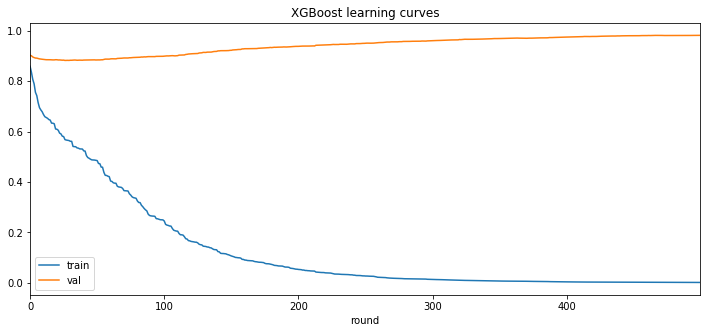

In [92]:
# https://www.youtube.com/watch?v=s3VmuVPfu0s

evals_result = clf.evals_result()
train_errors = evals_result['validation_0']['f1_err']
val_errors = evals_result['validation_1']['f1_err']
df = pd.DataFrame([train_errors, val_errors]).T
df.columns = ['train', 'val']
df.index.name = 'round'
df.plot(title='XGBoost learning curves', figsize=(12, 5))

# Random forest imbalanced also without dask

In [46]:
BalancedRandomForestClassifier??

In [22]:
clf = BalancedRandomForestClassifier(n_jobs=20, class_weight='balanced')

In [23]:
clf.fit(X_train_split_numpy, y_train_split_numpy)

BalancedRandomForestClassifier(bootstrap=True, class_weight='balanced',
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=20, oob_score=False, random_state=None,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [24]:
y_val_pred_numpy = clf.predict(X_val_split_numpy)
cf = confusion_matrix(y_val_split_numpy, y_val_pred_numpy)
print(cf)

print('F1 score: ', f1_score(y_val_split_numpy, y_val_pred_numpy))

[[210102 275342]
 [  7962  16861]]
F1 score:  0.10636982455697638


# Submission

In [65]:
def write_submission(filename, y_pred):
    df = pd.DataFrame(y_pred, columns=['Target'])
    df.index.name = 'Id'
    print(df.Target.value_counts())
    df.to_csv(filename)

In [48]:
pipeline = Pipeline([
    ('std', StandardScaler()),
    ('clf', SGDClassifier(random_state=0, tol=1e-04, **gs.best_params_))
])

with ProgressBar():
    pipeline.fit(X_train_arr, y_train_arr)


In [59]:
pipeline['clf']

SGDClassifier(alpha=0.1, average=False,
              class_weight={0: 0.5256760365234032, 1: 10.23670526493175},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [58]:
gs.best_params_

{'alpha': 0.1,
 'class_weight': {0: 0.5256760365234032, 1: 10.23670526493175},
 'loss': 'hinge'}

In [54]:
y_test_pred = pipeline.predict(X_test_arr)

In [57]:
write_submission(join(DATA_PATH, 'first_submission.csv'), y_test_pred)

1    474335
0    234704
Name: Target, dtype: int64


Score on LB: 0.16634

### Github -> https://github.com/take5v/DAT300.git